In [1]:
import time

import jax
import jax.numpy as jnp
import diffrax

from rodas5 import Rodas5
from rodas5batched import Rodas5Batched

In [2]:

def f(t, y, args):
    return jnp.array([
        -0.04 * args[0]**2 * y[0] + 10e4 * y[1] * y[2],
         0.04 * args[0]**2 * y[0] - 10e4 * y[1] * y[2] - (1 + t) * 3 * 10e7 * y[1]**2, 
        (1 + t) * 3 * 10e7 * y[1]**2
        ])


In [3]:
t0, t1 = 0.0, 7
y0 = jnp.array([2., 0.])

maxsteps = 5000

N = 10000

stepsize = t1/N
saveat = diffrax.SaveAt(ts=list(jnp.arange(t0, t1, stepsize)))

integrator = Rodas5()

2024-07-25 08:53:59.646612: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:


rtol = 1e-6
atol = 1e-6

n_total = 512

n_batch = 128

arg_total = jnp.arange(1, n_total + 1).reshape((n_total, 1))
y0_total = jnp.array([[2.0 + 0.5*(0.5 - k/n_total), 0.0, 0.0] for k in range(n_total)]).astype(float)

stepsize_controller = diffrax.PIDController(rtol=rtol, atol=atol)
term = diffrax.ODETerm(f)


def solve(y, args):
    return diffrax.diffeqsolve(term, 
                    integrator, 
                    t0=t0, 
                    t1=t1, 
                    dt0=stepsize, 
                    y0=y, 
                    saveat=saveat, 
                    stepsize_controller=stepsize_controller, 
                    max_steps=maxsteps,
                    args=args)



solve_vmap = jax.vmap(solve, (0, 0))
start = time.time()
solutions_vmap = solve_vmap(y0_total, arg_total)
end = time.time()

print("time: ", end-start)


/home/tobias/Projects/integrators/.venv/lib/python3.12/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/home/tobias/Projects/integrators/.venv/lib/python3.12/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/home/tobias/Projects/integrators/.venv/lib/python3.12/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


time:  3.138298511505127


In [5]:
%timeit solve_vmap(y0_total, arg_total)

1.92 s ± 16.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
integrator_batched = Rodas5Batched()

f_batched = jax.vmap(f, (None, 0 , 0))
term_batched = diffrax.ODETerm(f_batched)

y0_batched = jnp.array([y0_total[k:k+n_batch] for k in range(0,n_total,n_batch)])
arg_batched = jnp.array([arg_total[k:k+n_batch] for k in range(0,n_total,n_batch)])

def solve_batch(y, args):
    return diffrax.diffeqsolve(term_batched, 
                    integrator_batched, 
                    t0=t0, 
                    t1=t1, 
                    dt0=stepsize, 
                    y0=y, 
                    saveat=saveat, 
                    stepsize_controller=stepsize_controller, 
                    max_steps=maxsteps,
                    args=args)

solve_batch_vmap = jax.vmap(solve_batch, (0,0))

start = time.time()
solutions_batch = solve_batch_vmap(y0_batched, arg_batched)
end = time.time()

print("time: ", end-start)

/home/tobias/Projects/integrators/.venv/lib/python3.12/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/home/tobias/Projects/integrators/.venv/lib/python3.12/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/home/tobias/Projects/integrators/.venv/lib/python3.12/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


time:  1.705916166305542


In [7]:
%timeit solve_batch_vmap(y0_batched, arg_batched)

389 ms ± 841 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
solutions_batch.ys.shape, solutions_batch.ts.shape, solutions_vmap.ys.shape

((4, 10000, 128, 3), (4, 10000), (512, 10000, 3))

In [9]:
batch_ys =  []
for k in range(n_total // n_batch):
    for j in range(n_batch):
        intermediate = solutions_batch.ys[k, :, j, :].squeeze()
        batch_ys.append(solutions_batch.ys[k, :, j, :].squeeze())

batch_ys = jnp.array(batch_ys)
batch_ys.shape

(512, 10000, 3)

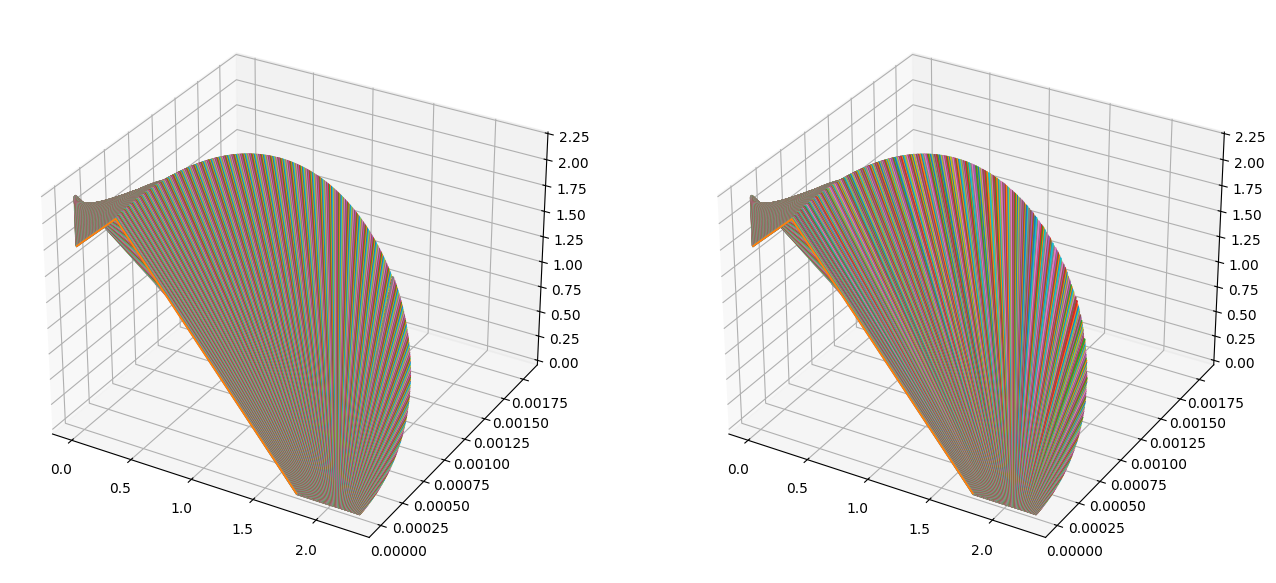

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_size_inches(16,8)

ax1 = fig.add_subplot(1, 2, 1, projection='3d')

for solution in batch_ys:
    ax1.plot(solution[:,0], solution[:,1], solution[:,2])

ax2 =fig.add_subplot(1, 2, 2, projection='3d')
for solution in solutions_vmap.ys:
    ax2.plot(solution[:,0], solution[:,1], solution[:,2])



plt.show()

In [11]:
for index, (sol_batch, sol_vmap) in enumerate(zip(batch_ys, solutions_vmap.ys)):
    norm = jnp.linalg.norm(sol_batch[-1] - sol_vmap[-1])

    if norm > 10e-5:
        print(index, sol_batch[-1], sol_vmap[-1])